Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

### Install libraries and initiate a frozen lake map

In [ ]:
# Install gymnasium game environment
!pip install gymnasium
!pip install gymnasium[toy-text]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 6.8 MB/s eta 0:00:00


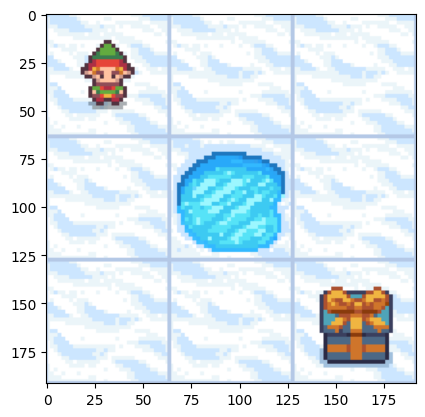

In [ ]:
# Load libraries
import gymnasium as gym
import matplotlib.pyplot as plt

# Define environment map
custom_map = [
    'SFF',
    'FHF',
    'FFG'
]

# Initialize the environment\
env = gym.make('FrozenLake-v1', desc=custom_map, is_slippery=False, render_mode='rgb_array')
state_size = env.observation_space.n    # Number of states
action_size = env.action_space.n    # Number of actions of this game: four, 0: left, 1:down, 2: right, 3: up.
env.reset()    # Reset environment, i.e., set agent position to state 0
plt.imshow(env.render())    # Visualize environment map

### Solution

In [ ]:
# Load libraries
import numpy as np
import random
import matplotlib
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque
import imageio
import pandas as pd

In [ ]:
# Define agent attibutes and methods
class Agent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2048)   # Deque is quick for append and pop operations from both the ends of the container.
        self.batch_size = 256
        self.learning_rate = 0.001    # Learning rate
        self.epsilon = 1    # Start (max) value of epsilon
        self.min_eps = 0.01    # End (min) value of epsilon
        self.eps_decay = 0.003     # Decay factor for decreasing epsilon over episodes
        self.gamma = 0.9    # Discount factor
        self.state_size = state_size    # Number of states
        self.action_size =  action_size    # Number of possible actions the agent can take: four, 0: left, 1:down, 2: right, 3: up.
        self.episode = 0     # Agent current episode
        # self.epsilon_lst = []    # Track epsilon values over episodes
        self.max_steps = 50    # Maximum number of steps the agent can carry out in an episode
        self.train_episodes = 501    # Number of training episodes
        self.model = self.build_model()    # Agent policy (and target model)

    # Build model architecture and compile it
    def build_model(self):
        model = Sequential()    # Initiate a simple sequential model
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))    # Add a fully connected layer
        model.add(Dense(self.action_size, activation='linear'))    # Add a fully connected layer connecting to the network output
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))    # Compile model with Mean Squared Error loss function
        return model

    def build_target_model(self):
        model = Sequential()
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # Add an eposide to agent's memory
    def add_memory(self, state, action, reward, new_state, terminated):
        self.memory.append((state, action, reward, new_state, terminated))    # Insert the value in its argument to the right end of the deque

    # Get action when agent is at a certain state
    def action(self, state):
        if np.random.rand() > self.epsilon:     # Epsilon starts at 1. rand > epsilon: exploit, rand <= epsilon: explore.
            return np.argmax(self.model.predict(state, verbose=0))     # Take greedy action. Verbose=0 mutes output prediction log.
        return env.action_space.sample()    # Take a random action in the action space

    # Train policy network
    def replay(self):
        ### Process data batch
        minibatch = random.sample(self.memory, self.batch_size)    # Select a data batch for training
        minibatch_state = np.concatenate(np.array(minibatch, dtype=object)[:, 0], axis=0)    # Extract 'state' batch from the data batch
        minibatch_action = np.array(minibatch, dtype=object)[:, 1]    # Extract 'action' batch from the data batch
        minibatch_reward = np.array(minibatch, dtype=object)[:, 2]    # Extract 'reward' batch from the data batch
        minibatch_new_state = np.concatenate(np.array(minibatch, dtype=object)[:, 3], axis=0)    # Extract 'new_state' batch from the data batch
        minibatch_terminated = np.array(minibatch, dtype=object)[:, 4]    # Extract 'terminated' batch from the data batch

        ### Feed state to the network for training
        q_state = self.model.predict(minibatch_state, verbose=0)    # First pass: feed current state to the network to get current Q-values
        q_new_state = self.target_model.predict(minibatch_new_state, verbose=0)    # Second pass: feed new state to the target network to get next Q-values

        q_action_optimal = np.add(minibatch_reward, self.gamma * np.amax(q_new_state, axis=1))    # Calculate the optimal Q-values of actions from the current state
        for i in range(0, self.batch_size):
            q_state[i][minibatch_action[i]] = q_action_optimal[i]    # Update optimal Q-values back to 'q_state' variable

        self.model.fit(minibatch_state, q_state, epochs=1, verbose=0)    # Train the network with the optimal Q-values, i.e., now in 'q_state' variable. x is minibatch_state and y is q_state. Loss is MSE.
    # Update the target model with the weights of the policy model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Save model
    def save_model(self, name):
        self.model.save_weights(name)

    # Load model
    def load_model(self, name):
        self.model.load_weights(name)

# Initialize a reinforcement learning agent
agent = Agent(state_size, action_size)

# Initialize the target network
agent.target_model = agent.build_target_model()

In [ ]:
reward_episodes = []    # Track rewards over episodes
step_episodes = []    # Track number of steps (in each episode until termination) over episodes
epsilon_episodes = []    # Track epsilon values over episodes

for episode in range(agent.train_episodes):
    agent.episode = episode    # Set agent's current episode
    state = env.reset()    # Reset environment, i.e., agent position is set to state 0
    state_arr = np.zeros(agent.state_size)    # Initialze current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    state_arr[state[0]] = 1    # Set the agent position in the current state array, i.e., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape array
    reward = 0    # Initialize reward to zero
    terminated = False    # Initialize terminated to False

    img_lst = [env.render()]    # Initialize list to store visualization frames
    for step in range(agent.max_steps):
        action = agent.action(state_arr)    # Take action at the current state. This ccan be exploitation or exploration, depending on agent.epsilon
        new_state, reward, terminated, info, _ = env.step(action)     # Terminated: whether a terminal state is reached after taking the action. Ref: https://www.gymlibrary.dev/api/core/#gym.Env.step
        new_state_arr = np.zeros(agent.state_size)    # Initialze new state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr[new_state] = 1    # Set the agent position in the new state array, after taking the action, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])    # Reshape array
        agent.add_memory(state_arr, action, reward, new_state_arr, terminated)    # Add current step to agent's memory
        state_arr = new_state_arr    # New state becomes state

        # Render map imgage for visualization every K episodes
        if agent.episode % 50 == 0:
            animation_file = "training_episode_" + str(agent.episode) + "_steps_" + str(step) + ".gif"
            img = env.render()    # Render current environment image
            img_lst.append(img)    # Append environment images to make animation

        if terminated:    # if agent reaches Goal
            break    # End episode

    print("Episode: " + str(agent.episode) + ", Steps: " + str(step) + ", epsilon: " + str(round(agent.epsilon,2)) + ", Reward: " + str(reward))
    reward_episodes.append(reward)    # Add reward to list for tracking purpose
    step_episodes.append(step)    # Add step to list for tracking purpose
    epsilon_episodes.append(agent.epsilon)    # Add epsilon to list for tracking purpose

    ### Update epsilon value which is the ratio of exploitation and exploration
    if agent.epsilon < agent.min_eps:
        agent.epsilon = agent.min_eps    # Set the minimum value of epsilon so that there is always a chance for exploration.
    else:
        agent.epsilon = np.exp(-agent.eps_decay*agent.episode)    # Decrease exploration / Increase exploitation overtime as the agent knows more about the environment

    ### If enough experiences collected in the memory, use them for training
    if len(agent.memory) > agent.batch_size:
        agent.replay()

        ### Update the target network with the weights of the policy network periodically
        if episode % 10 == 0:  # Update the target network every 10 episodes
            agent.update_target_model()

    ### Write animation of the training episode (n*K)th
    if len(img_lst)>1:
        imageio.mimsave(animation_file, img_lst, format='GIF', duration=0.5)

print('Average success rate of training episodes: ', round(np.mean(reward_episodes),2))
agent.save_model('model_' + str(agent.episode))    # Save model

Episode: 0, Steps: 9, epsilon: 1, Reward: 0.0
Episode: 1, Steps: 1, epsilon: 1.0, Reward: 0.0
Episode: 2, Steps: 3, epsilon: 1.0, Reward: 0.0
Episode: 3, Steps: 1, epsilon: 0.99, Reward: 0.0
Episode: 4, Steps: 6, epsilon: 0.99, Reward: 0.0
Episode: 5, Steps: 9, epsilon: 0.99, Reward: 0.0
Episode: 6, Steps: 5, epsilon: 0.99, Reward: 1.0
Episode: 7, Steps: 12, epsilon: 0.98, Reward: 0.0
Episode: 8, Steps: 17, epsilon: 0.98, Reward: 0.0
Episode: 9, Steps: 3, epsilon: 0.98, Reward: 0.0
Episode: 10, Steps: 3, epsilon: 0.97, Reward: 0.0
Episode: 11, Steps: 6, epsilon: 0.97, Reward: 0.0
Episode: 12, Steps: 1, epsilon: 0.97, Reward: 0.0
Episode: 13, Steps: 1, epsilon: 0.96, Reward: 0.0
Episode: 14, Steps: 38, epsilon: 0.96, Reward: 0.0
Episode: 15, Steps: 6, epsilon: 0.96, Reward: 0.0
Episode: 16, Steps: 1, epsilon: 0.96, Reward: 0.0
Episode: 17, Steps: 5, epsilon: 0.95, Reward: 0.0
Episode: 18, Steps: 20, epsilon: 0.95, Reward: 1.0
Episode: 19, Steps: 18, epsilon: 0.95, Reward: 1.0
Episode: 2

In [ ]:
# Print the optimal policy, i.e., at each state what is the best action to take.
for state_index in range(agent.state_size):
    state_arr=np.zeros(agent.state_size)    # Initialize state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr[state_index] = 1    # Set the agent position as if it is currently at each of the state
    state_arr= np.reshape(state_arr, [1, agent.state_size])    # Reshape state array
    q_values = agent.model.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # # Get max-Q-value action, i.e., best action to take
    print("State " + str(state_index) + ", Best action: " + str(best_action))

State 0, Best action: 1
State 1, Best action: 2
State 2, Best action: 1
State 3, Best action: 1
State 4, Best action: 0
State 5, Best action: 1
State 6, Best action: 2
State 7, Best action: 2
State 8, Best action: 2


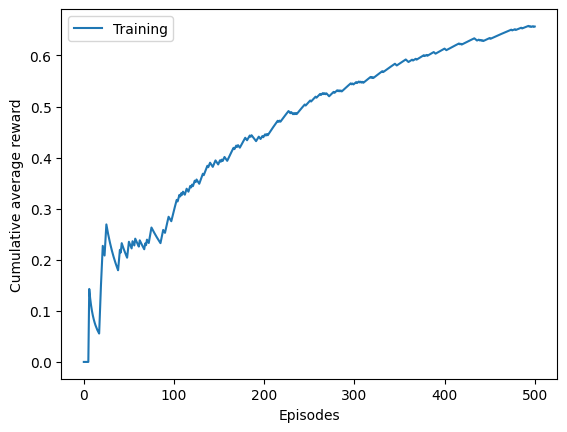

In [ ]:
# Plot cumulative average reward (or success rate) of the training phase.
# This shows how well the agent performs in the training phase.
df_reward_episodes = pd.DataFrame(reward_episodes)
cumulative_average_rewards = df_reward_episodes.expanding().mean()
plt.plot(cumulative_average_rewards)
plt.ylabel('Cumulative average reward')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper left')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

In [ ]:
# Print the optimal policy, i.e., at each state what is the best action to take.
for state_index in range(agent.state_size):
    state_arr=np.zeros(agent.state_size)    # Initialize state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr[state_index] = 1    # Set the agent position as if it is currently at each of the state
    state_arr= np.reshape(state_arr, [1, agent.state_size])    # Reshape state array
    q_values = agent.model.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # # Get max-Q-value action, i.e., best action to take
    print("State " + str(state_index) + ", Best action: " + str(best_action))

State 0, Best action: 1
State 1, Best action: 2
State 2, Best action: 1
State 3, Best action: 1
State 4, Best action: 0
State 5, Best action: 1
State 6, Best action: 2
State 7, Best action: 2
State 8, Best action: 2


In [ ]:
# Load the saved agent model.
# agent.load_model('model_500')    # Uncomment this line if you want to load a saved model from file

# Test an episode
state = env.reset()    # Reset environment, i.e., agent position is set to state 0
state_arr = np.zeros(agent.state_size)    # Initialze current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr[state[0]] = 1    # Set the agent position in the current state array, i.e., [1. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape array, e.g., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
terminated = False    # Initialize terminated to False
img_lst = [env.render()]    # Initialize list to store visualization frames
for step in range(agent.max_steps):
    q_values = agent.model.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # Get max-Q-value action, i.e., best action to take
    new_state, reward, terminated, info, _ = env.step(best_action)    # Perform the best action, get return from environment
    new_state_arr = np.zeros(agent.state_size)    # Initialze new state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr[new_state] = 1    # Set the agent position in the new state array, after taking the action, e.g., [0. 1. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])    # Reshape array, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
    print("Current state: " + str(np.argmax(state_arr)) + ", Action: " + str(best_action) + ", New state: " + str(np.argmax(new_state_arr)))
    state_arr = new_state_arr    # New state becomes state

    img = env.render()    # Render current environment image
    img_lst.append(img)    # Append environment images to make animation

    if terminated:    # If agent reaches Goal or Hole
        break    # End episode

print("Reward: " + str(reward))    # Print reward of the test episode
imageio.mimsave('test.gif', img_lst, format='GIF', duration=0.5)

Current state: 0, Action: 1, New state: 3
Current state: 3, Action: 1, New state: 6
Current state: 6, Action: 2, New state: 7
Current state: 7, Action: 2, New state: 8
Reward: 1.0


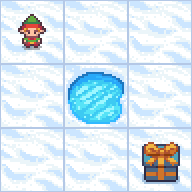

In [ ]:
# Display test result animation
from IPython.display import Image
Image('test.gif')